#Text analysis

#### We will split the text analysis up to three parts. 

###1. Firstly, the comments for each game are analyzed and how they differ between communites of our built network. 

### 2. Seccondly, Discriptions of the games are analyzed and how they differ between communities of our built network.


###3. Thirdly, the comments for each genre are analyzed and how they differ. 

#### The aim of this analysis is to get insight into the comments on steam and analyze if they differ between the communities found in the basic analysis and between genres. As the connection of the games in our networks are dependent on the genres they have in common, the community text analysis should give us some insight into weather surtain genres have more possitive comments than others. As we have 26 genres, the community analysis should allow us split the games up to fewer clusters and find commonalities within the comments of those clusters.  Is it maybe the case that players of Adventure based games are more possitive than players of Action based games? We will explore these kind of patterns in this analysis. 

#### We also decide to analyze the text of the descriptions of the games, to get insight into how connected games in our network have similar descriptions, and which words are the most popular when descriping a surtain cluster. 

In [3]:
#Packages used in this notebook
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import re 
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import numpy as np
import math
import community as cmg #the package should be installed before
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We have already downloaded the comments and stored them in a dictionary along with their game id, so we start by retrieving the comments. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open ('/content/drive/MyDrive/final project/comm_dict_300.p', 'rb') as fp:
    dict_comments_300 = pickle.load(fp)

## Network for exploring communites later
GN = nx.read_gml("/content/drive/MyDrive/final project/finalNet.gml")

In [ ]:
print("example of one row of the dictionary:")
print(dict_comments_300["730"])

example of one row of the dictionary:
[{'weight': '0.895013153553009033', 'comment': 'great game, lots of cheaters.'}, {'weight': '0.841927528381347656', 'comment': 'full of idiots'}, {'weight': '0.645188987255096436', 'comment': 'love/hate relationship with this fucking game'}, {'weight': '0.626354098320007324', 'comment': 'good'}, {'weight': '0.612296521663665771', 'comment': 'Small children cheater zone asf!!'}, {'weight': '0.599346578121185303', 'comment': 'After 10,000 hours and over 6 years of playing this game, I just wanna put in my 2 cents and say this game is ass compared to what it should be.'}, {'weight': '0.598777532577514648', 'comment': 'Too many hackers'}, {'weight': '0.594002306461334229', 'comment': 'love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate love hate'}, {'weight': '0.59173

Above an example of the dictionary can be seen. Each value has the game-id as it's key and a list containg dictionaries of the weight of the comments and the comment themselves.  The weight of the comment is defined by steam in the API call. 

The journal happiness score list will be used to assign the words in the comments a rating  for sentiment analysis.  Many words are not ranked in that list so we will look into that below.

In [ ]:
# opening and storing every sentiment related words
#word	happiness_rank	happiness_average	happiness_standard_deviation	twitter_rank	google_rank	nyt_rank	lyrics_rank
sentiment_url = "https://journals.plos.org/plosone/article/file?type=supplementary&id=10.1371/journal.pone.0026752.s001"
word_list = pd.read_csv(sentiment_url, sep='\t', header = 2)
word_list = word_list[["word", "happiness_average"]]
# sentiment calculator function (pandas is exploit)

#Later we see which words are not in the happiness score list
words_not_in = []


Let's plot the average number of comments per game. 

average number of comments per game:  60.65846560846561


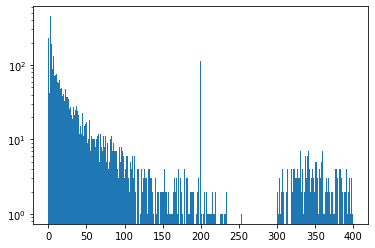

In [ ]:
tot_comm=0
num_comm=[]
for game in dict_comments_300.keys():
  tot_comm+=len(dict_comments_300[game])
  num_comm.append(len(dict_comments_300[game]))
         
ave_comm=tot_comm/len(dict_comments_300)
print("average number of comments per game: ",ave_comm)
_ = plt.hist(num_comm, bins=400, log=True)

The average number of comments are only 60 comments so we do not have that much data to work with. We notice that some games have very few comments. We keep them in the analysis for now but will look into it better below. 

In [ ]:
#with open ('/content/drive/MyDrive/final project/dict_total_sentiment.p', 'rb') as fp:
#    dict_total_sentiment = pickle.load(fp)

In [ ]:
#print(dict_total_sentiment)

In [ ]:
dict_tokenize_comments = deepcopy(dict_comments_300)
#dict_total_sentiment={}

Now we take each comment and lemmatize the words and calulate their sentiment rate. The average sentiment rate of a game is calculated as follows: 
1. Find the happiness score rank of a word and take the average for the comment to get the sentiment score of the comment.
2. The happiness score rank of a comment is multiplied by the weight of the comment from the API call.
3. After doing that for all the comments in a game, we devide 1 by 2 to get the average sentiment rate. 

We store the resault in a dictionary, with the game-id as the key and the average sentiment score as its value.

We create a function to calculate the sentiment of each word using the method mentioned above, and store the words that are not defined in the list. 

In [ ]:
def calculate_sentiment(words):
  #happiness_average NaN if not in sentiment_url
  all_merge =  pd.DataFrame(words, columns=["word"]).merge(word_list, on = "word", how = 'left')
  counter = all_merge[all_merge["happiness_average"].isnull()]["word"]
  #Words that are not in sentiment list
  for word in counter :
    #store the words that are not in happiness score ranking
    if word not in range(0,11) : 
      words_not_in.append(word)
  #average sentiment of comment
  avg = pd.DataFrame(words, columns=["word"]).merge(word_list, on = "word").happiness_average.mean()
  return avg


In [ ]:
i = 0
for game in dict_tokenize_comments.keys():
  #if i%50 == 0:
   # print(i)
  #i+=1
  num_valid_comm = 0
  average_sentiment_rate = 0
  for comment in range(len(dict_tokenize_comments[game])):
    wnl = nltk.WordNetLemmatizer()
    raw = dict_tokenize_comments[game][comment]["comment"]
    raw = raw.lower()
    tokens = re.findall(r'\w+', raw)
    lem_tokens = [wnl.lemmatize(t) for t in tokens]
    #calculate average sentiment of comment
    #words_not_in cotains all words not in sentiments
    sentiment_rate = calculate_sentiment(lem_tokens)
    
    if sentiment_rate!=0 and not(math.isnan(sentiment_rate)):
      num_valid_comm+=float(dict_tokenize_comments[game][comment]["weight"])
      average_sentiment_rate += sentiment_rate*float(dict_tokenize_comments[game][comment]["weight"])
  if num_valid_comm != 0:
    dict_total_sentiment[game]=average_sentiment_rate/num_valid_comm
  else:
    dict_total_sentiment[game] = 0



Let's look at the most common words that are not defined in the happiness ranking. 

<class 'collections.Counter'>
{'10': 35786, '2': 25968, 'gameplay': 25341, '3': 21479, '1': 17168, 'h1': 14876, '5': 14838, 'mechanic': 13827, '4': 12253, 'puzzle': 10316, 'dlc': 8156, 'devs': 7890, 'multiplayer': 7256, 'mod': 7023, '8': 6489, '100': 6353, 'rpg': 6139, 'bos': 5923, '6': 5893, 'spoiler': 5637, 'enjoyable': 5619, '7': 5584, '20': 5498, '9': 5051, 'fps': 4927, 'animation': 4512, 'genre': 4472, 'aren': 4396, 'frustrating': 4294, '30': 4150, '0': 4065, 'tutorial': 3994, 'simulator': 3848, 'shooter': 3824, 'vr': 3758, 'repetitive': 3746, 'unlock': 3635, 'npc': 3476, '50': 3436, 'controller': 3419, 'satisfying': 3296, '15': 3201, 'dungeon': 3176, 'ui': 3129, 'faction': 3021, 'realistic': 3017, 'crafting': 3014}


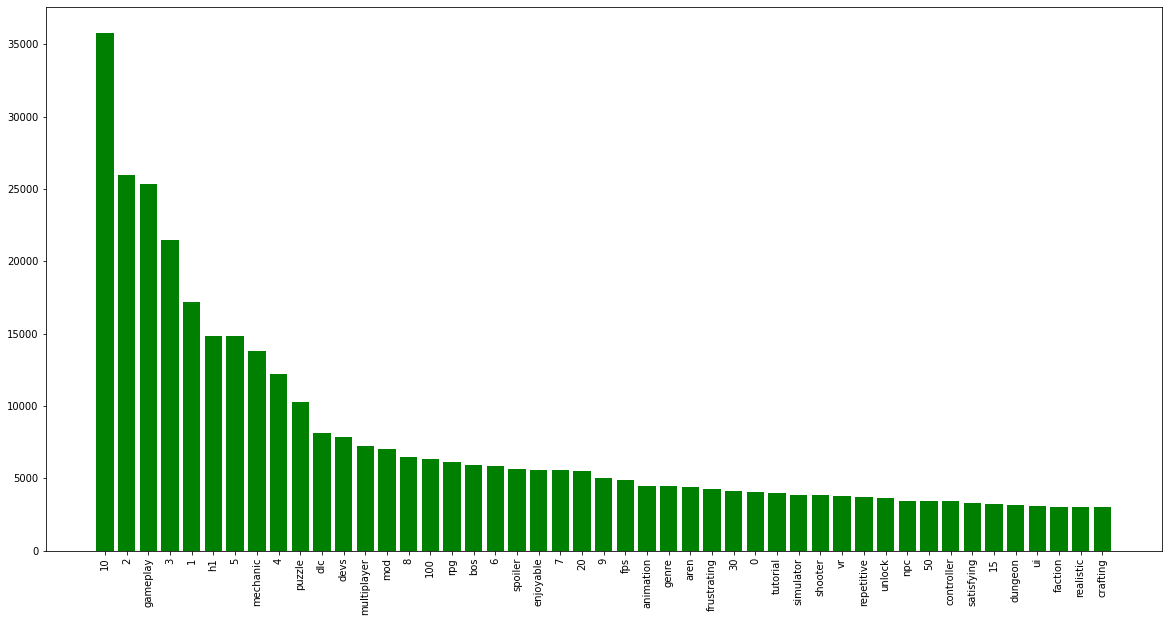

In [ ]:
from collections import Counter
import collections
words = Counter(words_not_in)

#Look at words that appear more than 3000 times. 
words_subset = {key: value for key, value in words.items() if value > 3000}

sorted_values = sorted(words_subset.values(), reverse = True) # Sort the values
sorted_dict= {}

for i in sorted_values:
    for k in words_subset.keys():
        if words_subset[k] == i:
            sorted_dict[k] = words_subset[k]
            break

#print the words and counts
print(sorted_dict)

#Vizualize the words and counts
plt.figure(figsize=(20,10)) 
plt.bar(sorted_dict.keys(), sorted_dict.values(),  color='g');
plt.xticks(rotation=90);


After looking at the words we add some words to the happiness score ranking that are common and give them a score similar to similar words in the happiness score ranking. Many of these words are numbers or neutral so we do not add them to the list. 

In [ ]:
df2 = pd.DataFrame({"word":["enjoyable", "frustrating", "repetitive", "satisfying", "realistic"
                            , "masterpiece", "glitch", "refund" , "playable", "unplayable" , "rewarding",
                            "flaw", "tedious", "addictive", 
                            "replayability", "lag", "toxic", "addicting" , 
                            "disappointing", "bland"], 
                    "happiness_average":[8, 3, 4, 7.5,8, 9, 2, 2, 6, 2, 7, 2, 2, 5, 6, 2, 2, 6, 2, 4]}) 

#Append the list to the word_list
word_list.append(df2)

,word,happiness_average
0,laughter,8.50
1,happiness,8.44
2,love,8.42
3,happy,8.30
4,laughed,8.26
...,...,...
15,lag,2.00
16,toxic,2.00
17,addicting,6.00
18,disappointing,2.00


Now we calculate the sentiment rate of a game again after adding these words to the happiness score ranking. 

In [ ]:
i = 0
for game in dict_tokenize_comments.keys():
  #if i%50 == 0:
    #print(i)
  #i+=1
  num_valid_comm = 0
  average_sentiment_rate = 0
  for comment in range(len(dict_tokenize_comments[game])):
    wnl = nltk.WordNetLemmatizer()
    #Tokanize words. 
    raw = dict_tokenize_comments[game][comment]["comment"]
    raw = raw.lower()
    tokens = re.findall(r'\w+', raw)
    lem_tokens = [wnl.lemmatize(t) for t in tokens]
    #calculate average sentiment of comment
    #words_not_in cotains all words not in sentiments
    sentiment_rate = calculate_sentiment(lem_tokens)
    
    if sentiment_rate!=0 and not(math.isnan(sentiment_rate)):
      num_valid_comm+=float(dict_tokenize_comments[game][comment]["weight"])
      average_sentiment_rate += sentiment_rate*float(dict_tokenize_comments[game][comment]["weight"])
  if num_valid_comm != 0:
    dict_total_sentiment[game]=average_sentiment_rate/num_valid_comm
  else:
    dict_total_sentiment[game] = 0



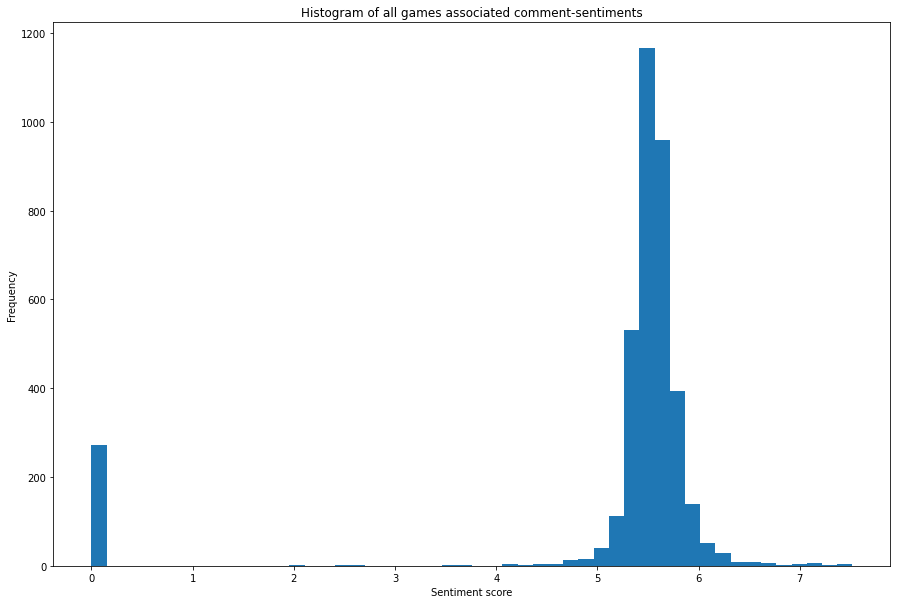

In [ ]:
# reorganize data
dataX = []
dataY = []

for game in dict_total_sentiment:
    dataX.append(game)
    dataY.append(dict_total_sentiment[game])

#Plot a histogram of the sentiment rate
plt.figure(figsize=(15,10))
plt.xlabel("Sentiment score")
plt.ylabel("Frequency")
plt.title("Histogram of all games associated comment-sentiments")
plt.hist(dataY, bins = 50)
plt.show()

In [6]:
with open ('/content/drive/MyDrive/final project/dict_total_sentiment.pkl', 'rb') as fp:
   dict_total_sentiment = pickle.load(fp)

Alot of games have 0 sentiment value. These comments are either empty, meaning tha the game didn't have any comments or that the words in the comments are not contained in the sentiment list. The third possability is that the weight defined in the API call is 0 making the total sentiment 0 according to how we defined the function above. Below an example of these comments can be found.

The other games' comments seam to be quite normally distributed, suggesting that the sentiment of the games comments do not vary drasticly. 


In [ ]:
#examples of comments with 0 sentiment:
search_age = 0
k = 0
for name, age in dict_total_sentiment.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if age == search_age:
        print(dict_comments_300[name])
        print(name)
        k += 1
    if k == 10 :
      break


[]
50100
[{'weight': 0, 'comment': "I'm automaticly connecting to a Taiwan region and everything is Chinese so i cannot read anything. I cannot change the language to english and cannot change the region server. I cannot even play the game. Better just refund it"}]
582660
[{'weight': '0.523809552192687988', 'comment': ':-)'}, {'weight': '0.523809552192687988', 'comment': ':-)'}]
386360
[]
601510
[]
1147690
[]
1258080
[]
1046930
[]
766570
[]
1041320
[]
700330


Let's look at the games with the happiest comments:

In [ ]:
#Get the names of the games, as we only have their ID's
import urllib.request
steam_key = "867F8B5F0D8556E26387B363DEA1E027"
baseurl = "http://api.steampowered.com/ISteamApps/GetAppList/v0002/?key="
format ="&format=json"

In [ ]:
#build the request for obtaining the appid and name of all the app
all_app_req = "{}{}{}".format(baseurl, steam_key,format)
print(all_app_req)

http://api.steampowered.com/ISteamApps/GetAppList/v0002/?key=867F8B5F0D8556E26387B363DEA1E027&format=json


In [ ]:
#do the request and save the response
steamresponse = urllib.request.urlopen(all_app_req)
steamdata = steamresponse.read()
steamtext = steamdata.decode('utf-8')

In [ ]:
#save the response in a json document, then parse it to obtain the list {appid:###,name:"name"}
content = json.loads(steamtext)['applist']['apps']

In [ ]:
#all games by panda
all_games = pd.DataFrame(content)

In [ ]:
import operator

reverse_sorted_sentiment = sorted(dict_total_sentiment.items(), key=operator.itemgetter(1), reverse=True)
print("The games with the happiest comments are :\n")
for game in reverse_sorted_sentiment[:20]:
    id = int(game[0])
    print("\t", "nr. of comments:",len(dict_comments_300[game[0]]), ", score", round(game[1],3) ,"    ", all_games[all_games["appid"] == id].iloc[0]['name']) 
print('\n')


The games with the happiest comments are :

	 nr. of comments: 2 , score 7.52      Aozora Meikyuu
	 nr. of comments: 2 , score 7.38      Gnomes Garden 3: The thief of castles
	 nr. of comments: 2 , score 7.38      Planet R-12
	 nr. of comments: 2 , score 7.38      Gladiator Trainer
	 nr. of comments: 2 , score 7.22      Coloring Game
	 nr. of comments: 2 , score 7.2      Heroes of Might & Magic V: Tribes of the East
	 nr. of comments: 4 , score 7.2      Dirty Bomb
	 nr. of comments: 7 , score 7.2      我来自江湖
	 nr. of comments: 2 , score 7.2      MotoGP™19
	 nr. of comments: 2 , score 7.2      Tarim: Guardians
	 nr. of comments: 2 , score 7.15      High On Racing
	 nr. of comments: 2 , score 7.148      False Shelter
	 nr. of comments: 2 , score 7.06      SUPER DRAGON BALL HEROES WORLD MISSION
	 nr. of comments: 2 , score 6.944      Tales from the Void
	 nr. of comments: 2 , score 6.92      Dungeons: The Eye of Draconus
	 nr. of comments: 2 , score 6.89      Otaku's Adventure
	 nr. of com

We can see that the games with the happiest comments have very few comments. Let's look at the games that have more than 50 comments. 

In [ ]:
import operator

dict_more_sentiment = {}

for game in dict_comments_300: 
  if len(dict_comments_300[game]) > 50 : 
    dict_more_sentiment[game] = dict_total_sentiment[game]

reverse_sorted_sentiment = sorted(dict_more_sentiment.items(), key=operator.itemgetter(1), reverse=True)
print("The games with the happiest comments are :\n")
for game in reverse_sorted_sentiment[:20]:
    id = int(game[0])
    print("\t", "nr. of comments:",len(dict_comments_300[game[0]]), ", score", round(game[1],3) ,"    ", all_games[all_games["appid"] == id].iloc[0]['name']) 
print('\n')

The games with the happiest comments are :

	 nr. of comments: 57 , score 6.205      Counter-Strike: Condition Zero
	 nr. of comments: 67 , score 6.201      TerraTech
	 nr. of comments: 64 , score 6.13      NEKOPARA Vol. 2
	 nr. of comments: 65 , score 6.121      Steep
	 nr. of comments: 215 , score 6.094      Human: Fall Flat
	 nr. of comments: 86 , score 6.04      Feed and Grow: Fish
	 nr. of comments: 336 , score 6.031      Counter-Strike
	 nr. of comments: 59 , score 6.02      Aimbeast
	 nr. of comments: 83 , score 6.017      ShellShock Live
	 nr. of comments: 308 , score 6.012      Euro Truck Simulator 2
	 nr. of comments: 123 , score 6.009      Just Cause 3
	 nr. of comments: 133 , score 5.988      Pummel Party
	 nr. of comments: 77 , score 5.984      Stronghold Crusader HD
	 nr. of comments: 61 , score 5.984      Descenders
	 nr. of comments: 73 , score 5.97      Sonic Generations
	 nr. of comments: 54 , score 5.968      Sally Face
	 nr. of comments: 151 , score 5.963      Plane

If the reader knows anything about gaming, these resaults show that these resault are more significant, with one of the most popular games today being nr. 1 on the list: Counter Strike. 

In [ ]:
#with open ('/content/drive/MyDrive/final project/word_list.pkl', 'wb') as fp:
#  pickle.dump(word_list, fp)

In [ ]:
#with open ('/content/drive/MyDrive/final project/dict_total_sentiment.pkl', 'wb') as fp:
#  pickle.dump(dict_total_sentiment, fp)

In [4]:
with open ('/content/drive/MyDrive/final project/dict_total_sentiment.pkl', 'rb') as fp:
    dict_total_sentiment = pickle.load(fp)

In [ ]:
with open ('/content/drive/MyDrive/final project/words_not_in.p', 'wb') as fpl:
  pickle.dump(words_not_in, fpl)

In [5]:
with open ('/content/drive/MyDrive/final project/partition.p', 'rb') as fp:
    partition = pickle.load(fp)


#1. Analyze text in communities

We use the partition from the basic analysis and look at the word clouds for each community. 

In [ ]:
#Louvain method
#partition = cmg.best_partition(GN, random_state= 10) #random state in order to obtain always the same result
#The optimal modularity reached with the Louvain method
M = cmg.modularity(partition, GN)
print("Optimal Modularity: ", M)

Optimal Modularity:  0.4299667319417017


The partition dictionary contatins the game-id as key and the community that games belongs to as value. 

In [7]:
dict_token_comments={}
uniqueValues = set(partition.values())

Is there a differnce between the sentiment value of the comments within each community?

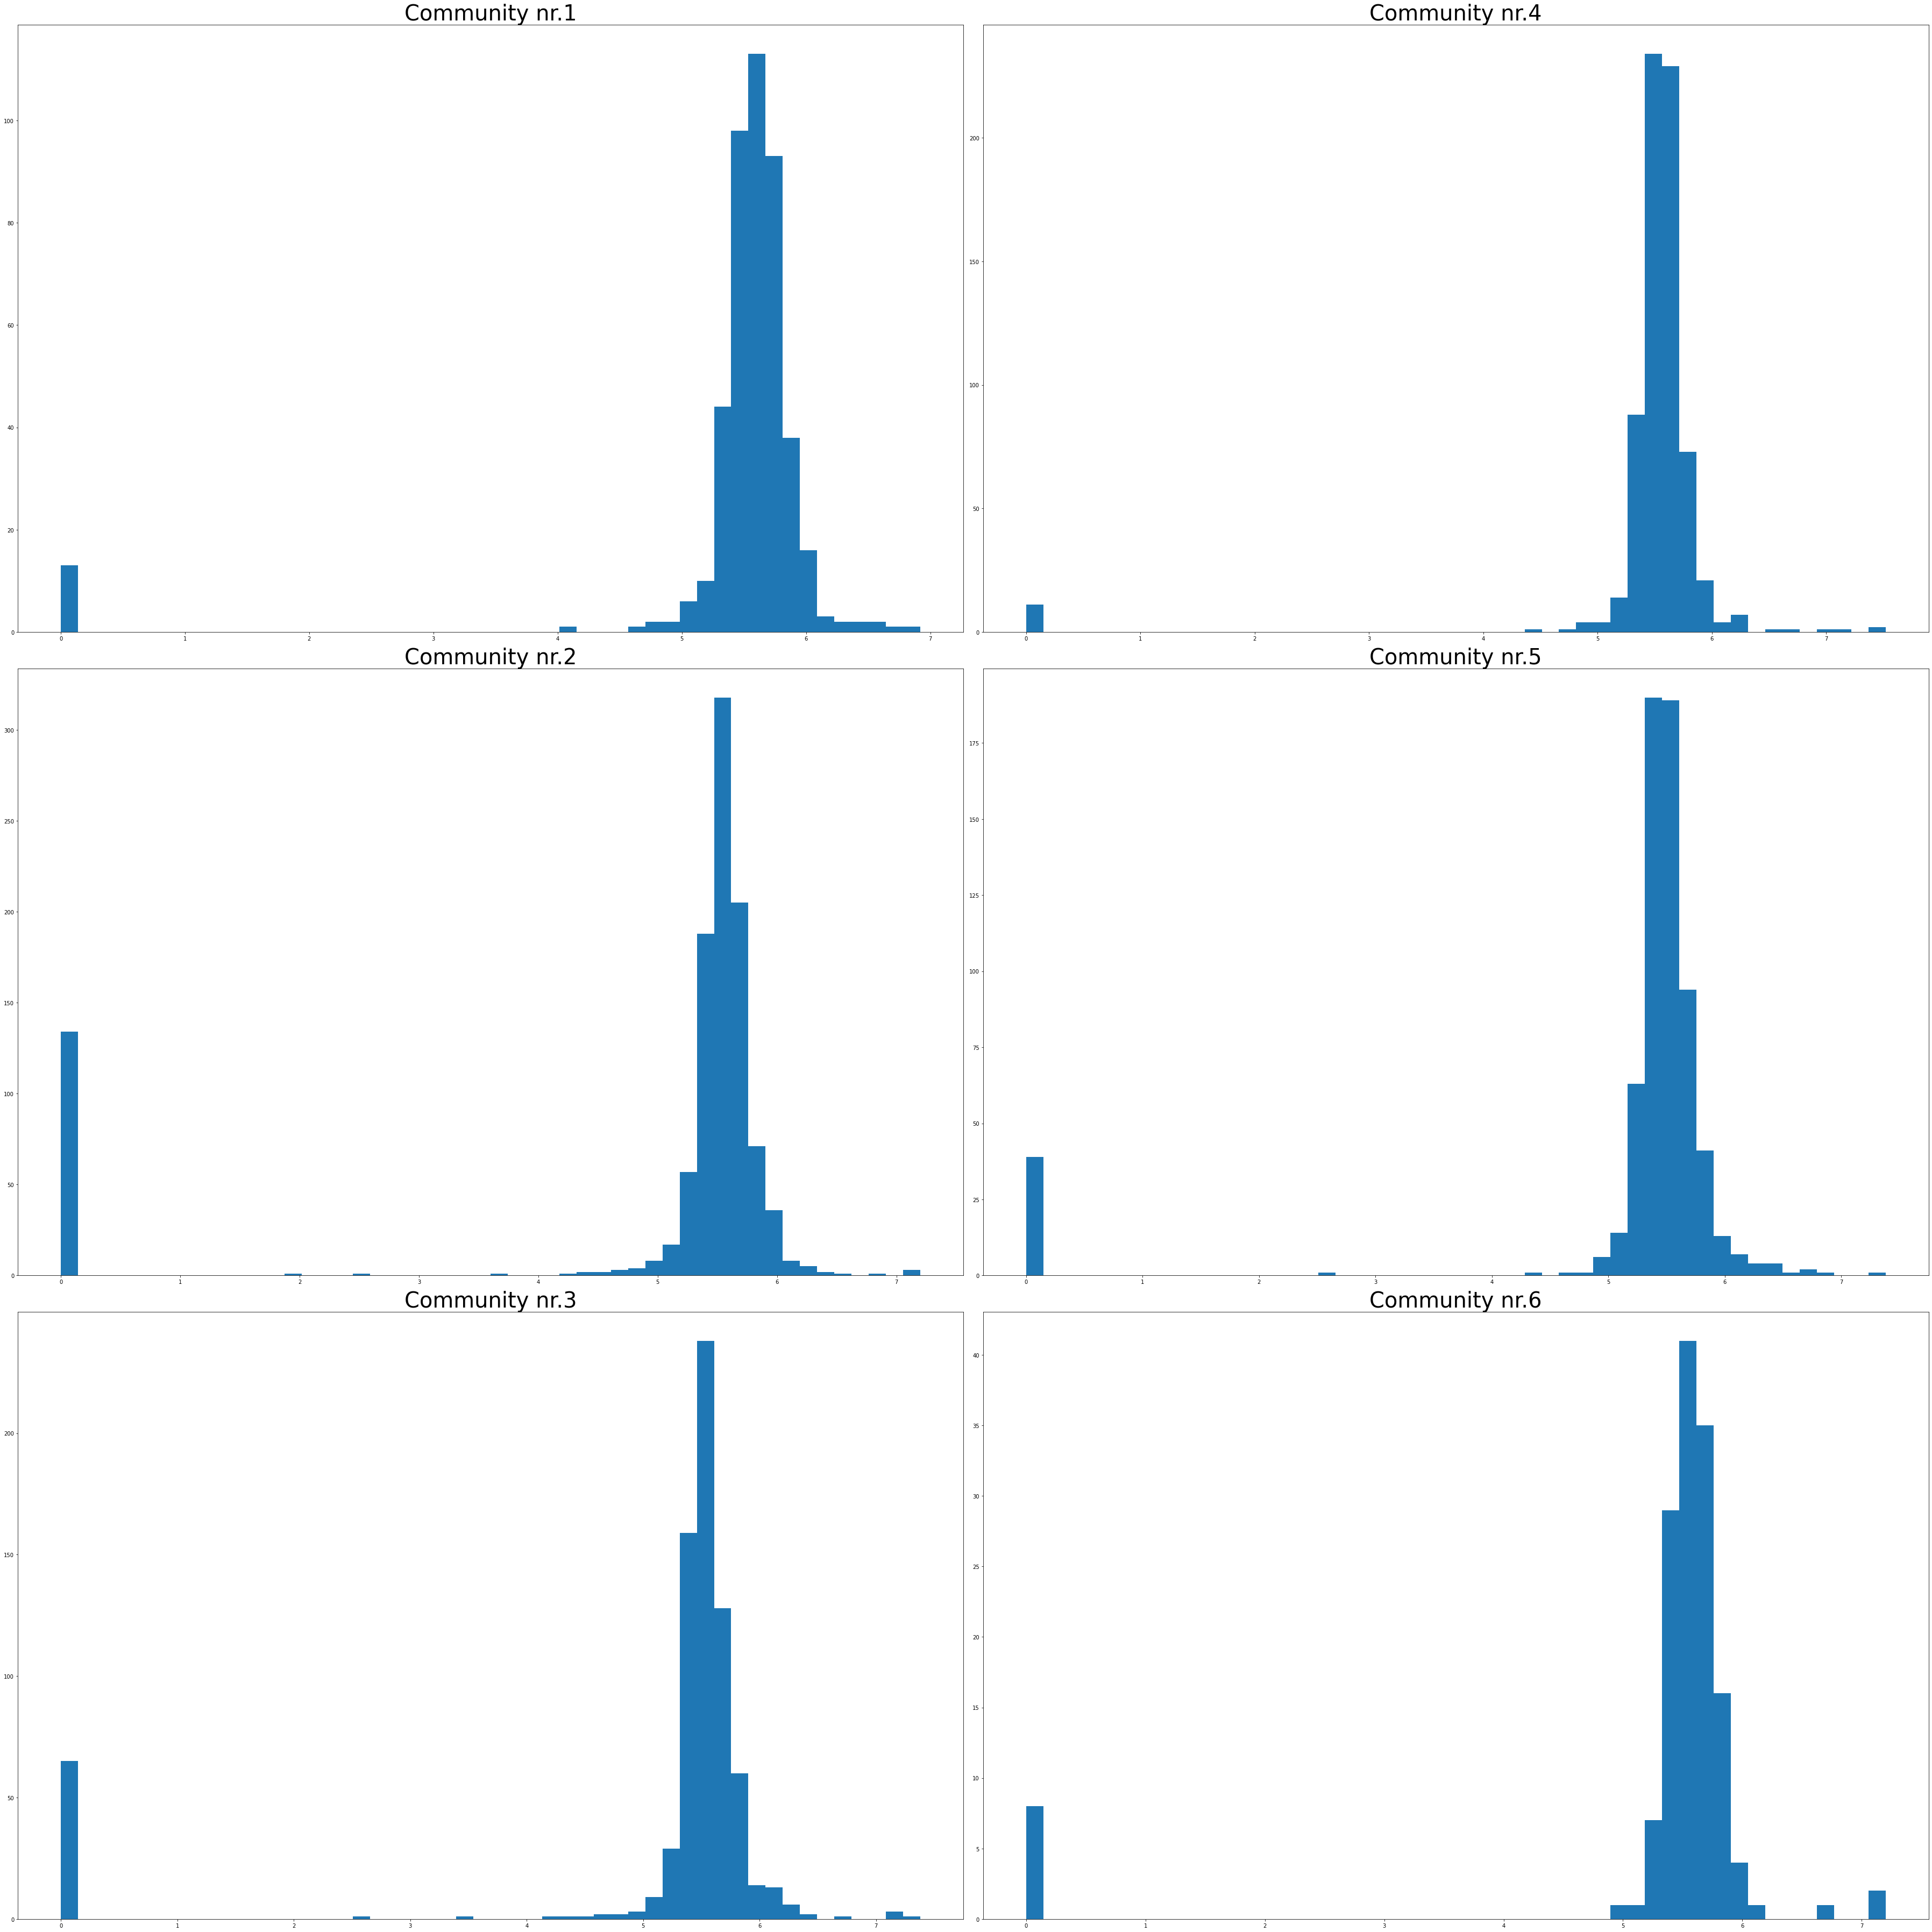

In [16]:
# reorganize data
j = 0
fig, axs = plt.subplots(3,2, figsize=(50, 50))

for i in range(0,6) : 
  dataX = []
  dataY = []
  for game in partition:
    if partition[game] == i : 
      dataX.append(game)
      dataY.append(dict_total_sentiment[game])

  k = i +1
  if i > 2:
      j = 1
    #dicTest = IDF_TF(documents_tokens, documents_tokens[i])
    # generate word cloud
  if i == 3: 
        i = 0
  if i == 4: 
        i = 1 
  if i == 5: 
        i = 2
    
  axs[i,j].hist(dataY, bins = 50)
  #axs[i,j].set_axis_off() 
  axs[i,j].set_title(str("Community nr." + str(k)) ,  fontsize=40)
  axs[i,j].plot()

fig.tight_layout()

plt.show()

We can see that the distribution of sentiments of game comments between the communites is quite similar. A normal distribution, with mean around 5.5. 

We split the comments up to communites. 

In [ ]:
#SPLIT COMMENTS TO COMMUNITES
#how many communites?
len_com = len(uniqueValues)

documents = [''] * len_com
i=0
noisy_words=nltk.corpus.stopwords.words('english')
#common noisy words that we are not interested in
noisy_words.append("game")
noisy_words.append("games")
noisy_words.append("play")
noisy_words.append("get")
noisy_words.append("like")
noisy_words.append("one")
noisy_words.append("really")
noisy_words.append("time")
noisy_words.append("even")
noisy_words.append("play")
noisy_words.append("get")
noisy_words.append("like")
noisy_words.append("would")
#Appeared of similar size in all word clouds
noisy_words.append("good")


for game in partition:
  ###dict_total_sentiment[game]
  str1 = ""
  #i+=1
  #if i%50==0:
  #  print(i)
  num_valid_comm = 0
  for comment in range(len(dict_tokenize_comments[game])):
    wnl = nltk.WordNetLemmatizer()
    raw = dict_tokenize_comments[game][comment]["comment"]
    str1 = raw
    raw = raw.lower()
    tokens = re.findall(r'\w+', raw)
    lem_tokens = [wnl.lemmatize(t) for t in tokens]
    # AND RANGE (0,11)??
    lem_tokens_stop = [w for w in lem_tokens if w not in noisy_words ]
    if partition[game] in dict_token_comments:
      dict_token_comments[partition[game]].extend(lem_tokens_stop)
      documents[partition[game]] += str1
    else:
      dict_token_comments[partition[game]] = lem_tokens_stop
      documents[partition[game]] = ""

In [ ]:
#with open ('/content/drive/MyDrive/final project/documents.p', 'wb') as fpl:
#  pickle.dump(documents, fpl)

In [ ]:
#with open ('/content/drive/MyDrive/final project/documents.p', 'rb') as fpl:
#  docs = pickle.load(fpl)

In [5]:
with open ('/content/drive/MyDrive/final project/documents.p', 'rb') as fpl:
  documents = pickle.load(fpl)

In [ ]:
with open ('/content/drive/MyDrive/final project/dict_token_comments2.p', 'wb') as fpl:
  pickle.dump(dict_token_comments,fpl)


In [ ]:
#with open ('/content/drive/MyDrive/final project/dict_token_comments2.p', 'rb') as fpl:
#  dict_token_comments = pickle.load(fpl)


Now we calculate the TD-IDF of the comments in each community. We take out common words that are not usefull in looking at the differences between communites and add them to our noisy words. 

The TF-IDF alogrimth (term frequency–inverse document frequency) reflects how important a word is in a document in a collection of documents.

The value increases proportionally to the number of times a word appears in a document and is offset by how many documents in the collection contain the word. So:


To calculate the term frequancy we count the number of times a word appears in a document and devide by the how many words are in the document, because the document lengths here vary..

$$T F(i, j)=\frac{\text { Term i frequency in document } j}{\text { Total words in document } j}$$

The inverse document frequency factor is used to lower the weights of words that occour frequently within the whole document set, so it measures how much information the word provied, how comon it is across all documents. So:


$$ \operatorname{IDF}(w, D)=\log \frac{N}{{N_c}} $$

Where N is the total number of documents and $N_c$ then number of documents where w appears.

We only loop trough words found in the documents so we do not need to take into acocunt when the number of documents where w appears is zero (leading to a division by zero).

Then tf-idf is calculated as
$$
\operatorname{TFIDF}(w, d, D)=\operatorname{TF}(w, d) \cdot \operatorname{IDF}(w, D)
$$


Since the ratio inside the idf's log function is always greater than or equal to 1, the value of idf (and tf–idf) is greater than or equal to 0. As a term appears in more documents, the ratio inside the logarithm approaches 1, bringing the idf and tf–idf closer to 0.

Although this implementation should take care of the stopwords, we keep them filtered out for computational efficiency.


####Wordclouds

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
fig, axs = plt.subplots(3,2, figsize=(50, 50))
documents_tokens = []

j = 0
for i in range(0,6) : 
    tfIdfVectorizer=TfidfVectorizer(use_idf=True, stop_words=noisy_words)
    tfIdf = tfIdfVectorizer.fit_transform(documents)
    df2 = pd.DataFrame(tfIdf[i].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df2 = df2.sort_values('TF-IDF', ascending=False)
    dic = {}
    if i < 5: 
      #Check the cosine similarity
      print(f'The cosine simmilarity between {i} and {i+1} is: {cosine_similarity(tfIdf[i], tfIdf[i+1])}')

    for row in df2.iterrows():
        #print(row[1]['TF-IDF'])
        dic[row[0]] = row[1]['TF-IDF']

    weighted_dict_a = dic
    wc = WordCloud(background_color="black", max_font_size=100, max_words=500)
    k = i +1
    if i > 2:
        j = 1
    #dicTest = IDF_TF(documents_tokens, documents_tokens[i])
    wc = WordCloud(background_color="black", max_font_size=100, max_words=500)# mask= a_mask )
    # generate word cloud
    if i == 3: 
        i = 0
    if i == 4: 
        i = 1 
    if i == 5: 
        i = 2
    
    # generate word cloud
    wc.generate_from_frequencies(weighted_dict_a)

    axs[i,j].imshow(wc, interpolation="bilinear")
    axs[i,j].set_axis_off() 
    axs[i,j].set_title(str("Community nr." + str(k)) ,  fontsize=40)
    axs[i,j].plot()
    sti = str(i)
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

The words "good", "one", "really" and "time" where filtered out before making the word clouds as they helt a very high weight and appeared large in all the word clouds allthough the TF-IDF should have filterd them out. 

We see that wordclouds for the communities are very similar.
We have compared the cosine similarity, a metric used to measure how similar the documents are irrespective of their size, to varify this. 
We can see that the cosine similarity varies between 0.88-0.96 so the document containing the comments for each community are very similar. 
 

These are some of the most notable differences: 
The word "fun" holds alot of weight in communities 1,2 and 3. 
The word "Story" holds alot of weight in communities 4 and 5. 
In community 6 the words "great", "best" and "first" hold alot of weight. 

From the basic analysis we know that these tags are the most popular within each community: 

1.  'Remote Play Together', 'Shared/Split Screen', 'Full controller support'
2. 'Action', 'Online PvP', 'PvP' (PvP = Player versus Environment)
3. 'Indie', 'Strategy', 'Casual'
4. 'Full controller support', 'Action', 'Adventure'
5.  'Indie', 'Adventure', 'Action'
6.  'Strategy', 'RPG', 'Simulation'

The conclusion is that the comments of the communities do not vary drasticly and no hypthosis can be made regarding these resaults. 




The algorithm used for calculating the TF-IDF of these word clouds was from a package provided by scikit-learn, an optimized alogirithm using vectorazation. The alogrighm uses $log(N/N_s +1) $ when calculating the IDF, so the words contained in all the documents do not get 0 weight. 
The same algorithm has been implemented below from scratch with only the $log(N/N_S)$ as IDF, so that the words contained in all the documents get 0 weight. As the cosine similarity between the documents is very similar, these wordclouds display words that are not frequent within the document, as most of the frequent words in the document are also in the other documents and thus filtered out. 

In [89]:
#most common words in each community
dict_comm_words={}
for comm in dict_token_comments:
  dict_comm_words[comm] = dict(nltk.FreqDist(dict_token_comments[comm]))

In [99]:
def TF(document) : 
    #document is a dictionary 
    d2 = {k: (v/len(document)) for k, v in document.items()}
    return(d2)

#function takes in all the documents and the specific document we want to get a TT-IDF dictionary for.
#Returns dictionary of IDF-TF scores for words in document d across all documents. 
def IDF_TF(documents_tokens, d) :
    N = len(documents_tokens)
    idfDict = {}
    Cdict = {}
    #count how many times a word within our document appears in the other documents.
    IDF = {}
    for word in d.keys():
        counter = 0
        for doc in documents_tokens:
            if word in documents_tokens[doc].keys(): 
                counter += 1
        IDF[word] = counter
    
    #calculate the TF score of the document from the function above
    Tf_score = TF(d)
    #now calclate TF-IDF score from these outputs like mentioned above
    idfDict = {k: np.log10(len(documents_tokens)/(IDF[k]))*v for k, v in Tf_score.items()}
    #idfDict = np.log10(len(documents_tokens)/counter)*TF(d)
    return(idfDict)

[('honk', 0.0078706438692717), ('medan', 0.006899556855031398), ('quiplash', 0.005287775130700293), ('tsubasa', 0.004835345172993316), ('madden', 0.004646553154724719), ('pga', 0.004609130194139827), ('golf', 0.004472829320830015), ('prom', 0.004282457571705245), ('wwe', 0.0040397271830255954), ('jackbox', 0.003866348333968702), ('bearer', 0.0037192557333389155), ('messi', 0.0036645607960839313), ('2k21', 0.003619439661655815), ('rollback', 0.0034170112408057627), ('tekken', 0.0033635496717037143), ('spiritfarer', 0.003251840321018897), ('pe', 0.00317385313752745), ('mycareer', 0.00294079472509535), ('2k20', 0.0028780888943444154), ('fifa', 0.0023803898531455877), ('wrestler', 0.002271262922645292), ('putt', 0.002064211682038082), ('trine', 0.0019799567286304222), ('pinball', 0.001906871441498347), ('nba', 0.0019033838164734449), ('wingspan', 0.0017248892137578496), ('netcode', 0.0016509155433106493), ('spelunky', 0.0015882861956571423), ('chronicon', 0.0015604096415120323), ('2k19', 0

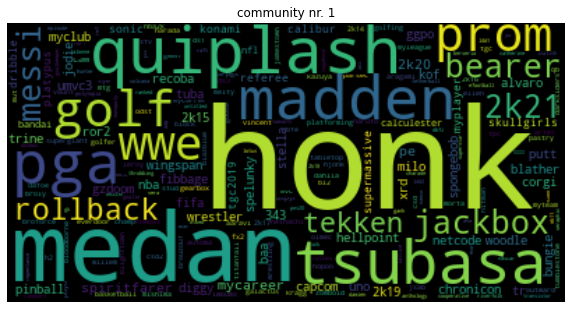

[('necromunda', 0.0037930075976237254), ('mordheim', 0.003750490750724843), ('lopez', 0.003118361977493023), ('temtem', 0.0029875232695724856), ('bakerloo', 0.002203842359093627), ('monkey', 0.002151001019712373), ('xen', 0.002095862478346236), ('aquanox', 0.002008944735500313), ('ganger', 0.001963968360824933), ('tsw', 0.0018017063410344838), ('capcom', 0.0017631226626435399), ('athorize', 0.001724094362556239), ('pst', 0.001694110112772652), ('cst', 0.0016791179878808584), ('mst', 0.0016791179878808584), ('shadowverse', 0.0016191494883136851), ('tems', 0.0015591809887465116), ('bigfoot', 0.0015591809887465116), ('re3', 0.001535127341595708), ('bf1', 0.001499212489179338), ('evrima', 0.001499212489179338), ('aeiou', 0.001499212489179338), ('forza', 0.0014847348738050862), ('flight', 0.0014828177242272528), ('nexon', 0.0014692282393957514), ('ck2', 0.0014615358914018815), ('block', 0.0014233219513415912), ('scriptum', 0.0014156264108128084), ('battlefront', 0.0014093381809946715), ('ba

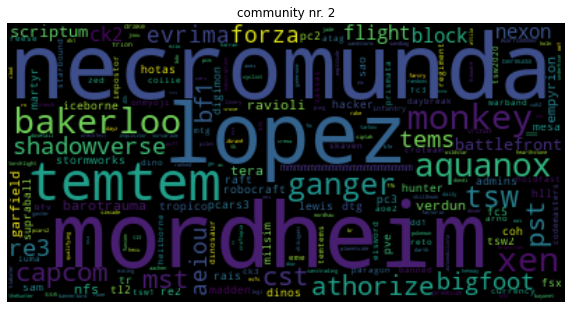

[('mhmm', 0.004527203251092362), ('chinners', 0.003650826908191522), ('ploop', 0.0024531444055125805), ('solasta', 0.0023764836428403126), ('skyborn', 0.002115837049754601), ('rimworld', 0.0019295966881322441), ('congestion', 0.0017631975414621672), ('vagary', 0.0015753568165483964), ('sophie', 0.0015485474059798163), ('seductively', 0.001500339825284187), ('griftlands', 0.001500339825284187), ('colonist', 0.001380708480657676), ('block', 0.0013307558624283487), ('barents', 0.0013002945152462955), ('xcom', 0.0012976778008383513), ('townscaper', 0.001275288851491559), ('qud', 0.0012478829474164843), ('partisan', 0.001209188902535353), ('5e', 0.0011600214694050147), ('clicker', 0.0011246540940599045), ('lobotomy', 0.0011192471350151148), ('tropico', 0.0010425863723428467), ('kenshi', 0.0010185554365507445), ('factorio', 0.0010015795126082324), ('idle', 0.0009948863139760695), ('dotp', 0.000986698144468848), ('dirk', 0.0009752208864347216), ('fomt', 0.0009752208864347216), ('yeam', 0.0009

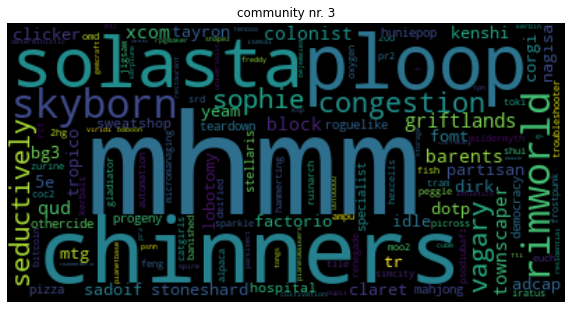

[('soy', 0.032873696873346576), ('potatoman', 0.011753092810418678), ('ashleyi', 0.008633870231700523), ('nexomon', 0.0067899099227345435), ('majima', 0.005204448722502112), ('dontnod', 0.004601284135457165), ('kiwami', 0.004239385383230198), ('danganronpa', 0.0042221521093146275), ('yakuza', 0.003733374619564811), ('arkham', 0.0029209450554259922), ('darkwood', 0.002809023648237895), ('kiryu', 0.0026711574569133357), ('tdd', 0.002602224361251056), ('deemo', 0.002483135378020124), ('metroidvania', 0.002468569052182447), ('batmobile', 0.0024471248960109267), ('firewatch', 0.002292937774597306), ('frictional', 0.0022666917333072066), ('kupo', 0.0022230923351085185), ('episode', 0.0021744418013698624), ('lara', 0.002173357367818086), ('violett', 0.0021369259655306685), ('stein', 0.0021024594176995287), ('elex', 0.0019473599524593996), ('amicia', 0.0019473599524593996), ('soma', 0.001903099048128016), ('noita', 0.0018702764336577104), ('ori', 0.001852401737419688), ('kojima', 0.00173335250

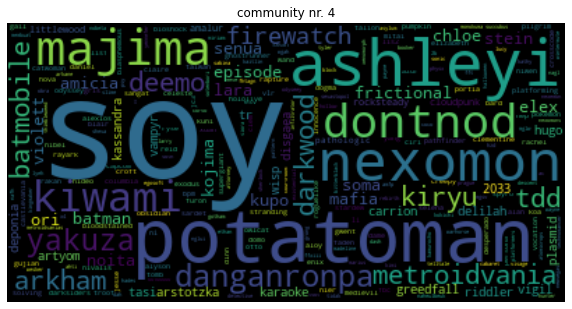

[('ㅤ', 0.0038883260481381316), ('rl1', 0.002973425801517395), ('hektor', 0.002973425801517395), ('superhot', 0.0029420574951912037), ('mommayo', 0.0024016131473794345), ('rl2', 0.002287250616551842), ('zigfrak', 0.0018298004932414738), ('ultrakill', 0.0017530266183622824), ('subnautica', 0.001746872908293858), ('solarix', 0.0015438941661724936), ('gdnomad', 0.0013151691045173095), ('syberia', 0.0012446488990372206), ('spaceport', 0.001209588366669975), ('mcd', 0.0012008065736897173), ('rpgmaker', 0.0011502781184206212), ('boneworks', 0.0011281573853740708), ('ːsundriveː', 0.001115034675569023), ('seatruck', 0.001000672144741431), ('vambies', 0.0009720815120345329), ('ac', 0.0009571455321919596), ('katana', 0.0009446053504107528), ('deer', 0.0009164159350774082), ('pilgrim', 0.0008958896883852915), ('stickmin', 0.0008737689553387411), ('momma', 0.0008516482222921907), ('exanima', 0.0008291283485000428), ('metroidvania', 0.000821677256864148), ('funlots', 0.0008005377157931447), ('gamegu

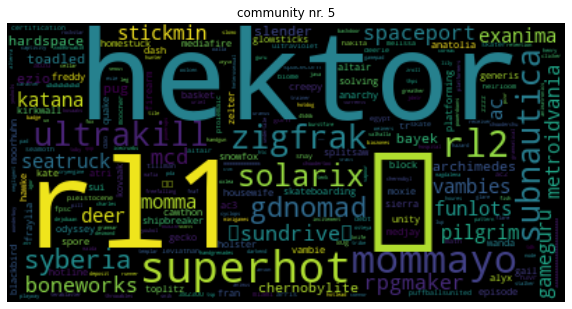

[('fallout3', 0.001895895259681424), ('rct3', 0.0015809494845013667), ('brigade', 0.001544509630154109), ('anno', 0.0015101871939284621), ('openrct2', 0.0014408803973578821), ('richmond', 0.0013650445869706253), ('neutrality', 0.0012133729661961113), ('acw', 0.001162462856251005), ('coh', 0.001162462856251005), ('aoe2', 0.0011159643420009648), ('retreated', 0.0011159643420009648), ('1861', 0.0011159643420009648), ('koikatsu', 0.0010694658277509246), ('nobunaga', 0.0010229673135008844), ('splicer', 0.0010229673135008844), ('bioware', 0.0009267057780924653), ('spearman', 0.0009100297246470835), ('coincidently', 0.0009100297246470835), ('emodiment', 0.0009100297246470835), ('denerim', 0.0009100297246470835), ('geralt', 0.0008580609056411717), ('gog', 0.0008102554171134009), ('rct', 0.0007904747422506833), ('excommunicated', 0.0007583581038725696), ('caveman2cosmos', 0.0007583581038725696), ('drowners', 0.0007583581038725696), ('fose', 0.0007583581038725696), ('hgl', 0.0007583581038725696)

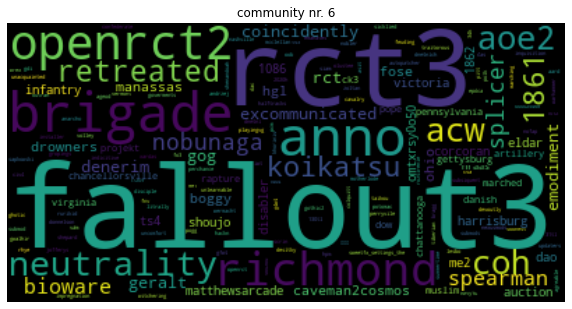

In [108]:
# See that our alorighm gives the same resault. 
for comm in dict_token_comments:
  dicTest = IDF_TF(dict_comm_words, dict_comm_words[comm]) #compute the TF_IDF for the community
  sort_dic =  sorted(dicTest.items(), key=operator.itemgetter(1), reverse=True)
  print(sort_dic[:50])
  #print(dict_comm_words[comm][sort_dic[0]])
  wc = WordCloud(background_color="black", max_font_size=100, max_words=500)
  wc.generate_from_frequencies(dicTest)
  plt.figure(figsize=(10,6))
  plt.title(f"community nr. {comm +1}")
  plt.imshow(wc, interpolation="bilinear")
  plt.axis('off')
  plt.show()

These wordclouds are very differnt from the once plotted above. The weights of the words here are very low, so we can not draw any conclusions from these wordclouds, as these words appear very infrequently within the communities. The reason is that most of the frequent words used within the comunities are also used within the other comunites, giving those word a weight of 0 as explained above. 

Let's look at collocations within the comments. 

In [6]:
from nltk.corpus import webtext
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

#nltk.download('punkt')

count = 1
for j in documents : 
  words = wordpunct_tokenize(j)
  tokens = words
  finder = BigramCollocationFinder.from_words(tokens, window_size = 10)
  stopset = set(stopwords.words('english'))
  #Add words to stopset that we are not interested in 
  stopset.add("https")
  stopset.add("}---")
  stopset.add("://")
  #these words did not give interesting resaults
  stopset.add("The")
  stopset.add("This")
  stopset.add("game")
  #filter out short words also
  filter_stops = lambda w: len(w) < 3 or w in stopset
  finder.apply_word_filter(filter_stops)
  print("community: ", count)
  #filter out dublicate words
  finder.apply_ngram_filter(lambda w1, w2,: w1 == w2)
  #sort the most common w
  print(sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:10])
  count += 1

community:  1
[(('curse', 'Bearer'), 984), (('fun', 'play'), 838), (('feel', 'like'), 775), (('play', 'friends'), 762), (('one', 'games'), 717), (('Bearer', 'curse'), 660), (('Dark', 'Souls'), 623), (('feels', 'like'), 609), (('would', 'recommend'), 599), (('like', 'games'), 543)]
community:  2
[(('feel', 'like'), 2335), (('early', 'access'), 2220), (('GAME', 'TOP'), 2172), (('TOP', 'GAME'), 2160), (('feels', 'like'), 2063), (('fun', 'play'), 1793), (('would', 'recommend'), 1521), (('one', 'games'), 1502), (('single', 'player'), 1428), (('really', 'good'), 1412)]
community:  3
[(('mhmm', 'yea'), 2103), (('yea', 'mhmm'), 2100), (('noises', 'writing'), 1770), (('writing', 'noises'), 1770), (('feel', 'like'), 1017), (('early', 'access'), 865), (('Town', 'Love'), 840), (('Love', 'Town'), 830), (('feels', 'like'), 820), (('really', 'like'), 790)]
community:  4
[(('SUPER', 'HOT'), 4739), (('HOT', 'SUPER'), 4736), (('AshleyI', 'hate'), 2495), (('hate', 'AshleyI'), 2495), (('feel', 'like'), 24

#2. Text analysis between genres

The response from the API call made in another notebook is stored as valid_response and contains the genre for each game. 

In [ ]:
#Get the response from the API call
with open ('/content/drive/MyDrive/final project/valid_responses.p', 'rb') as fp:
    short_desc = pickle.load(fp)
#with open ('/content/drive/MyDrive/final project/comm_dict_300.p', 'rb') as fp:
#    dict_comments_300 = pickle.load(fp)


We create a dictionary containg a genre as key and the games in that genre as values. 

In [ ]:
to_be_do = [node for node in GN.nodes()]

#Dictionary containing the genre as key and the game id's as values
dict_genres = {}

#CAMBIA GN.nodes() CON to_be_do
i=0
for node in short_desc:
  for key, value in node.items(): 
    if key in to_be_do: 
      for k, v in value["data"].items():
          if k == "genres":
            for t in v :
              tjekk = t["description"]
              if tjekk in dict_genres :
                dict_genres[tjekk].append(key)
              else :
                dict_genres[tjekk]  = []
                dict_genres[tjekk].append(key)

  i += 1

Now we get the comments for each game and store in a dictionary, with the genre as key and a list of all the comments in that genre as value. 

In [ ]:
dict_tokenize_comments = deepcopy(dict_comments_300)

In [ ]:
documents = ['']*len(dict_genres)
i=0
noisy_words=nltk.corpus.stopwords.words('english')

c = 0

for genre in dict_genres: 
  for vals in dict_genres[genre]: 
    ###dict_total_sentiment[game]
    str1 = ""
    #if c%50==0:
    #  print(c)
    #c += 1
    num_valid_comm = 0
    if vals in to_be_do :
      for comment in range(len(dict_tokenize_comments[vals])):
        wnl = nltk.WordNetLemmatizer()
        raw = dict_tokenize_comments[vals][comment]["comment"]
        str1 = raw
        raw = raw.lower()
        tokens = re.findall(r'\w+', raw)
        lem_tokens = [wnl.lemmatize(t) for t in tokens]
        # AND RANGE (0,11)??
        lem_tokens_stop = [w for w in lem_tokens if w not in noisy_words ]
        #Documents contains the commments split to genres
        documents[i] += str1
  i = i+1



In [ ]:
with open ('/content/drive/MyDrive/final project/doc_genres.pkl', 'wb') as fp:
  pickle.dump(documents, fp)

In [ ]:
with open ('/content/drive/MyDrive/final project/doc_genres.pkl', 'rb') as fp:
  documents = pickle.load(fp)

We store the names of the genres. 

In [ ]:
#Witch genres do we have?
names = []
for key in dict_genres : 
  names.append(key)

###Worclouds

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#fig, axs = plt.subplots(3,2, figsize=(50, 50))
documents_tokens = []

noisy_words = nltk.corpus.stopwords.words('english')
noisy_words.append("br")
noisy_words.append("https")
noisy_words.append("li")
noisy_words.append("com")
noisy_words.append("img")
noisy_words.append("png")
noisy_words.append("bb_tag")
noisy_words.append("net")
noisy_words.append("cdn")
noisy_words.append("quot")
noisy_words.append("src")
noisy_words.append("h2")
noisy_words.append("h1")
noisy_words.append("class")
noisy_words.append("ul")
noisy_words.append("pngnew")
noisy_words.append("game")
noisy_words.append("play")
noisy_words.append("player")
noisy_words.append("players")
noisy_words.append("games")
noisy_words.append("world")
noisy_words.append("new")
noisy_words.append("features")
noisy_words.append("time")
noisy_words.append("system")
noisy_words.append("like")
noisy_words.append("get")
noisy_words.append("one")
noisy_words.append("even")
noisy_words.append("really")
noisy_words.append("would")


from sklearn.metrics.pairwise import cosine_similarity

kat = 0
j = 0

#print(print(documents[0][0:100]))

#Print the word clouds for all genres
for i in range(0,len(dict_genres)) : 
    tfIdfVectorizer=TfidfVectorizer(use_idf = True, stop_words=noisy_words )#(use_idf=True) #
    tfIdf = tfIdfVectorizer.fit_transform(documents)
    print("lenght of comments in genre ", names[i], "is: ",  len(documents[i]))
    if i < (len(dict_genres) -1) : 
      #Check the cosine similarity
      print(f'The cosine simmilarity between {names[i]} and {names[i+1]} is: {cosine_similarity(tfIdf[i], tfIdf[i+1])}')
    df2 = pd.DataFrame(tfIdf[i].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df2 = df2.sort_values('TF-IDF', ascending=False)
    #print(df2.head(5))
    dic = {}

    for row in df2.iterrows():
        #print(row[1]['TF-IDF'])
        dic[row[0]] = row[1]['TF-IDF']

    weighted_dict_a = dic
    #dicTest = IDF_TF(documents_tokens, documents_tokens[i])
    wc = WordCloud(background_color="black", max_font_size=100, max_words=500)# mask= a_mask )
    # generate word cloud
    wc.generate_from_frequencies(weighted_dict_a)
    #plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.title("Genre: " + str(names[i]) ,  fontsize=20)
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import time, psutil
uptime = time.time() - psutil.boot_time()
remain = 12*60*60 - uptime

These word clouds are more conclusive than the once between the communities. 
We see clearly here what words vary most between the comments in the genres. E.g. the comments in the "video Production" genre uses words like "effects", "software", "program" more frequently than in the other genres. The genre "Adventure" uses words like "story", "fun" and "great", more frequently than the other genres. There are 26 genres so we will not discuss them all but all of the wordclouds make sense regarding that specific genre.  

#3. Text analysis for the short description of games

We start by getting the short description of each game from the API call and store in a dictionary, with the game-id as key and the short description as value. 

In [ ]:
to_be_do = [node for node in GN.nodes()]

#We are reusing code from above so we keep the dictionary name as "dict_comments_300"
dict_comments_300 = {}

#CAMBIA GN.nodes() CON to_be_do
i=0
for node in short_desc:
  for key, value in node.items(): 
    for k, v in value["data"].items():
        if k == "detailed_description" : 
          desc = v
          dict_comments_300[key] = v

#Example of short desctiption
print(dict_comments_300["730"])



Counter-Strike: Global Offensive (CS: GO) expands upon the team-based action gameplay that it pioneered when it was launched 19 years ago.<br />
<br />
CS: GO features new maps, characters, weapons, and game modes, and delivers updated versions of the classic CS content (de_dust2, etc.).<br />
<br />
&quot;Counter-Strike took the gaming industry by surprise when the unlikely MOD became the most played online PC action game in the world almost immediately after its release in August 1999,&quot; said Doug Lombardi at Valve. &quot;For the past 12 years, it has continued to be one of the most-played games in the world, headline competitive gaming tournaments and selling over 25 million units worldwide across the franchise. CS: GO promises to expand on CS' award-winning gameplay and deliver it to gamers on the PC as well as the next gen consoles and the Mac.&quot;


We can see that the short description will need some filtering, which we look into below. 

Let's check the average number of words per short description of game.

Average number of words per desctiption of game:  2263.589037503278


Text(0.5, 1.0, 'Words in description of game')

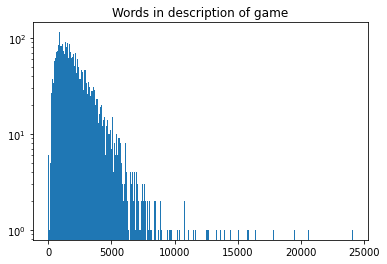

In [ ]:
tot_comm=0
num_comm=[]
i = 0
for game in dict_comments_300.keys():
  tot_comm+=len(dict_comments_300[game])
  num_comm.append(len(dict_comments_300[game]))
  i += 1
ave_comm=tot_comm/len(dict_comments_300)
print("Average number of words per desctiption of game: ",ave_comm)
_ = plt.hist(num_comm, bins=400, log=True)
plt.title("Words in description of game")

In [ ]:
dict_tokenize_comments = deepcopy(dict_comments_300)

Let's check if the average sentiment rate is similar to above for the comments. 

In [ ]:
i = 0
dict_total_sentiment={}
for game in dict_tokenize_comments.keys():
  #if i%50 == 0:
  #  print(i)
  #i+=1
  #num_valid_comm = 0
  average_sentiment_rate = 0
  #for comment in range(len(dict_tokenize_comments[game])):
  wnl = nltk.WordNetLemmatizer()
  raw = dict_tokenize_comments[game]
  raw = raw.lower()
  tokens = re.findall(r'\w+', raw)
  lem_tokens = [wnl.lemmatize(t) for t in tokens]
    #calculate average sentiment of comment
    #words_not_in cotains all words not in sentiments
  sentiment_rate = calculate_sentiment(lem_tokens)
  dict_total_sentiment[game] = sentiment_rate



Let's look at a histogram of the average sentiment rate.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


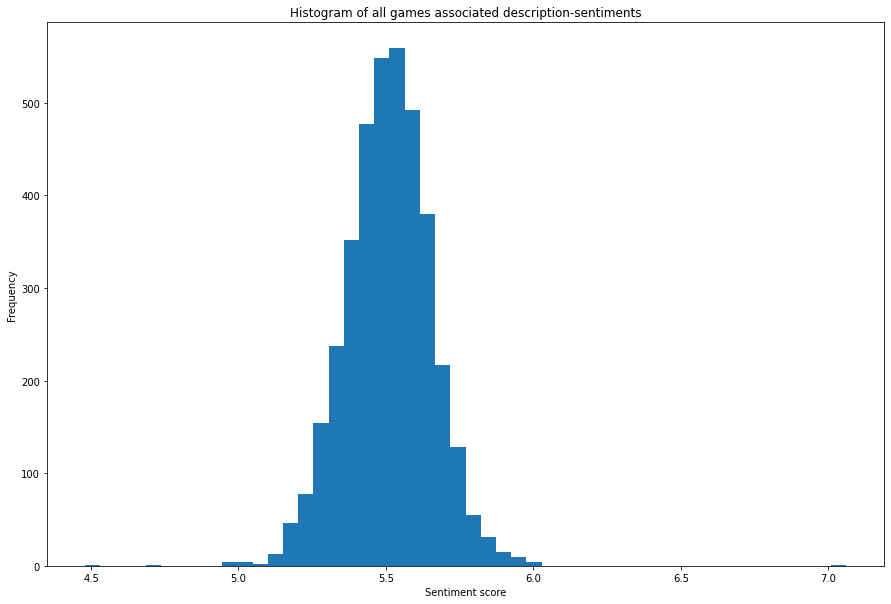

In [ ]:
# reorganize data
dataX = []
dataY = []

for game in dict_total_sentiment:
    dataX.append(game)
    dataY.append(dict_total_sentiment[game])

plt.figure(figsize=(15,10))
plt.xlabel("Sentiment score")
plt.ylabel("Frequency")
plt.title("Histogram of all games associated description-sentiments")
plt.hist(dataY, bins = 50)
plt.show()

We can see that the averge sentiment is normally distributed, which is not surprising as the descriptions of the games are quite neutral. 

Now we spit the short description of games to communites like we did in section 1 of analyzing the comments. 
We use regular expressions to get rid of some noise as discussed above. 

In [ ]:
#SPLIT DESCRIPTIONS TO COMMUNITES
dict_token_comments = {}
documents = [''] * 6
i=0
noisy_words=nltk.corpus.stopwords.words('english')
for game in partition:
  ###dict_total_sentiment[game]
  str1 = ""
  i+=1
  num_valid_comm = 0
  wnl = nltk.WordNetLemmatizer()
  raw = dict_tokenize_comments[game]
  # take out everything between < and >
  raw2 = re.sub("([\<]).*?([\>])", " ", raw)
  #take out websides
  raw2 = re.sub(r'http\S+', "", raw2)
  #if i%500==0:
  #  print(i)
  #  print(raw)
  #  print(raw2)
  raw = raw2
  str1 = raw
  raw = raw.lower()
  #find all words
  tokens = re.findall(r'\w+', raw)
  #lemmatize words
  lem_tokens = [wnl.lemmatize(t) for t in tokens]
  lem_tokens_stop = [w for w in lem_tokens if w not in noisy_words]
  if partition[game] in dict_token_comments:
    #add the words to the community containing the game
    dict_token_comments[partition[game]].extend(lem_tokens_stop)
    documents[partition[game]] += str1
   #if first game in that community
  else:
    dict_token_comments[partition[game]] = lem_tokens_stop
    documents[partition[game]] = ""

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
fig, axs = plt.subplots(3,2, figsize=(50, 50))
documents_tokens = []

noisy_words = nltk.corpus.stopwords.words('english')

noisy_words.append("br")
noisy_words.append("https")
noisy_words.append("li")
noisy_words.append("com")
noisy_words.append("img")
noisy_words.append("png")
noisy_words.append("bb_tag")
noisy_words.append("net")
noisy_words.append("cdn")
noisy_words.append("quot")
noisy_words.append("src")
noisy_words.append("h2")
noisy_words.append("h1")
noisy_words.append("class")
noisy_words.append("ul")
noisy_words.append("pngnew")
noisy_words.append("game")
noisy_words.append("play")
noisy_words.append("player")
noisy_words.append("players")
noisy_words.append("game")
noisy_words.append("world")
noisy_words.append("new")

from sklearn.metrics.pairwise import cosine_similarity

kat = 0
j = 0
for i in range(0,6) : 
    tfIdfVectorizer=TfidfVectorizer(use_idf=True, stop_words=noisy_words)#(use_idf=True) #
    tfIdf = tfIdfVectorizer.fit_transform(documents)
    print("length of words in community " , i+1 , "is", len(documents[i]))
    if i < 5: 
      print(f'The cosine simmilarity between {i} and {i+1} is: {cosine_similarity(tfIdf[i], tfIdf[i+1])}')
    df2 = pd.DataFrame(tfIdf[i].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df2 = df2.sort_values('TF-IDF', ascending=False)
    dic = {}

    for row in df2.iterrows():
        #print(row[1]['TF-IDF'])
        dic[row[0]] = row[1]['TF-IDF']

    weighted_dict_a = dic
    wc = WordCloud(background_color="black", max_font_size=100, max_words=500)
    k = i +1
    if i > 2:
        j = 1
    #dicTest = IDF_TF(documents_tokens, documents_tokens[i])
    wc = WordCloud(background_color="black", max_font_size=100, max_words=500)# mask= a_mask )
    # generate word cloud
    if i == 3: 
        i = 0
    if i == 4: 
        i = 1 
    if i == 5: 
        i = 2
    
    # generate word cloud
    wc.generate_from_frequencies(weighted_dict_a)

    axs[i,j].imshow(wc, interpolation="bilinear")
    axs[i,j].set_axis_off() 
    axs[i,j].set_title(str("Community nr." + str(k)) ,  fontsize=80)
    axs[i,j].plot()
    sti = str(i)
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

These word clouds for the short description of the games give more significant results than the wordclouds for the comments plotted above. 
Let's go over each community: 

1. Here we can see that the words "mode", "online", "mulitplayer" and "friends" carry much weight so we assume the games within this community are multiplayer games that you can play onlne with your friends.
These resaults clearly match the most common tags within the comunity from the basic statisics: 'Remote Play Together', 'Shared/Split Screen', 'Full controller support'.

2. "experience", "unique", "team", "battle" carry alot of weight so these games could be battle games that you play in teams.
These resaults clearly match the most common tags within the comunity from the basic statisics: 'Action', 'Online PvP', 'PvP' (PvP = Player versus Environment) 

3. "Build", "Create", "make", "unique", "different" carry alot of weight here so the games in this community are crafting games, focusing on building and creating. This maches the most comman tags from the basic statistics: 'Indie', 'Strategy', 'Casual'. 

4. The words "Story", "experience", "combat", "unique" and "characters" are heavy here, suggesting games that have a storyline where you experence playing different and unique character, maching the most common tags from the basic statistics: 'Full controller support', 'Action', 'Adventure'.

5. The words "find", "enimies", "story", "levels" are heavy here suggesting games that are adventurous containing some kind of story and charcters, matching the most common tags from the basic statistics: 'Indie', 'Adventure', 'Action'.

6. The words "War" ,"battle", "units" carry alot of weight here so we assume that this cumminity cointains strategy games. For example, many strategy games have hero or officer units that can improve the morale and combat performance of friendly units around them. These resaults also clearly match the most common tags from the basic statistics: 'Strategy', 'RPG', 'Simulation' (RPG = Role Playing Games)


#Discussion



We wanted to see if we could see similarities between the comments in communites. As we have 26 different genres, we expected the comments between genres to vary. We saw from part 2 that the comments between certain genres vary but not drasticly. As there are 26 genres we wanted to explore if we could split similar genre based games up to fewer clusters, communities, and analyze the comments in those clusters. As our analysis has shown both the sentiment rate and the content of the comments do not vary between communities and no hypothesis can be made after the analysis. 

The analysis on the short description of the games on the other hand showed that the description of games within communites contain similarites and that similar words are used to descripe games within these communites. From that we can conclude that the games within the communites are similar in there description, and therefor similar types of games. 